## Importing packages

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from matplotlib import rcParams
import colorlover as cl
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.tools as tls
from plotly.offline import init_notebook_mode
from sklearn.metrics import accuracy_score, recall_score
from sklearn import decomposition, manifold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest #For dropping outliers
from sklearn.tree import export_graphviz #Exports decision trees to dot file
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve
from plotly.offline import iplot
from imblearn.over_sampling import SMOTE #For resampling data
from IPython.display import Image
import warnings
import math
import itertools
import set_values
init_notebook_mode(connected = True)
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
params = {'legend.fontsize': 'large',
          'figure.figsize': (18,5),
          'font.size': 16,
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
           'axes.titlesize' :'large'
          
         }
rcParams.update(params)
paired_colors = sns.color_palette("Paired", 2)
colors = sns.color_palette("hls", 30)

## Defining functions for processing data

In [4]:
#Each country in the data set is given a alpha code.
#This functions returns data of a specific country by his alpha code.
def get_country_by_alpha(df,alpha):
    df = df[df.COUNTRY_ALPHA == alpha]
    df.reset_index(drop=True, inplace = True) #reindeixing the data frame
    return df

#This function returns the categorical part of a data frame
def get_categorical_data(df):
    return df.select_dtypes(include = ['object'])

#This function replace answers refused, don't know and didn't vote by 
#the most recurrent answer of the questions variables
#It takes in input the data frame where the answers will be replaced
#and a list of the encoded responses ex 9999, 9995
def encode_list(df, list_):
    for col in df.columns:
        inter = set(df[col].unique()).intersection(set(list_))
        if inter != set():
            inter_val = list(inter)[0]
            df[col].replace(inter_val,df[col][df[col] != inter_val].mode().loc[0], inplace = True)

#This function differs to the previous one by the way it replace values and is specifics
#to the answer don't know encoded as 9
def encode_value_9(df):
    for col in df.columns:
        if df[col].unique().dtype != 'object' and df[col].unique().max() == 9:
            df[col].replace(9,df[col][df[col] != 9].mode().loc[0], inplace = True)

#Thsi function uses Isolation Forest to drop outliers from the data
def get_non_outliers_index(df,estimator = IsolationForest):
    fitted = estimator(n_estimators = 100).fit(df)
    outliers_labs = fitted.predict(df)
    indices_non_outliers = outliers_labs != -1
    print('Number of outliers %d'%(df.shape[0] - indices_non_outliers.astype(int).sum()))
    return indices_non_outliers

#Some question have the response 'other' (answer not proposed by the interview)
#This function gets the new answer, and encode it
def encode_response_other(df,list_vals):
    new_encode_vals = {}
    new_encode = {}
    for col in df.columns:
        inter = set(df[col].unique()).intersection(set(list_vals))
        if inter != set():
            val =  df[col]
            idx = val == list(inter)[0]
            max_ = val[val != list(inter)[0]].max()
            val_2 = val[idx]
            new_encode_vals = {}
            for idx_2 in val_2.index:
                max_ += 1
                df[col][idx_2] = max_
                if col + 'OTHER' in df.columns:
                    new_encode_vals.update({df[col + 'OTHER'][idx_2]:max_})
            new_encode[col]= new_encode_vals
    return new_encode


In [5]:
#This function serves for data cleansing
def clean_data(df):
    df = df.select_dtypes(exclude = ['object']) #Kieeping only numeric data
    df = df.filter(regex=('Q.*')) #Using a regular expression to keep only questions asked to respondents
    df = df.loc[:,:'Q102'] #limiting the columns. Questions from Q103 to the end are filled the interviews and will not interest as
    df.dropna(how = 'all', axis = 1, inplace = True)#Dropping all columns that values as NaN, ex questions not asked in Niger
    for col in df.columns:
        counts = df[col].isna().astype(int).sum()
        if counts > 0.5*df.shape[0] :
            del df[col]
    refused = [98,998,9998]
    dont_know = [99,999,9999]
    not_vote_no_reply = [9997,9996]
    response_other = [995,9995]
    encode_list(df,refused) #setting refused answers by the mode of each column
    encode_list(df,dont_know)#setting don't know answers by the mode of each column
    encode_list(df,not_vote_no_reply)#setting not vote and not reply answers by the mode of each column
    encode_value_9(df)#setting don't answers encoded 9 by the mode of each column
    new_encode_response_other = encode_response_other(df,response_other) #getting reponses others and encoding them
    modes = df.mode().loc[0]
    df.replace(-1,modes, inplace = True)#replacing missing values encoded -1 by the mode
    df.fillna(modes, inplace = True)#filling NaN vaues by the mode
    return df, new_encode_response_other

In [7]:
#This function defines encoded variables
def get_values_names():
    regions_names = { 1100:'Agadez', 1101:'Diffa',
    1102:'Dosso', 1103:'Maradi', 1104:'Tahoua', 1105:'Tillabéri', 1106:'Zinder', 1107:'Niamey'}
    gender_names = {1:'Male',2:'Female'}
    lang_respondents_names = {2:'French',15:'Fulfuldé',16:'Haoussa',1101:'Zarma-Sonrai',1103:'Touareg',1104:'Béri-béri',1106:'Arabic',1107:'Toubou'}
    education = {0:'No formal schooling',1:'Informal schooling only',2:'Some primary schooling', 3:'Primary school completed'
                 , 4:'Some secondary school/ high school', 5:'Secondary school completed/high school completed', 6:'Post-secondary qualifications, other than university',
                 7:'Some university', 8:'University completed', 9:'Post-graduate'}
    return regions_names, gender_names, lang_respondents_names, education

#This function group ages
def get_age_groups(ages):
    cat_ages = []
    for i in range(ages.shape[0]):
        if ( ages[i] < 25):
            cat_ages.append('<25')
        if (25 <= ages[i] and ages[i] <= 35):
                cat_ages.append('25-35')
        if ( 36 <= ages[i] and ages[i] <= 45):
                cat_ages.append('36-45')
        if (46 <= ages[i] and ages[i] <= 55):
                cat_ages.append('46-55')
        if (56 <= ages[i] and ages[i] <= 65):
                cat_ages.append('56-65')
        if (66 <= ages[i] and ages[i] <= 75):
                cat_ages.append('66-75')
        if ( ages[i] >= 76):
                cat_ages.append('>76')
    return  pd.Series(cat_ages)

#This function replaced encoded variables 
def set_col_true_vals(col,col_value_names):
    col = col.replace(col_value_names, value = None)
    return col



## Defining functions for plottings

In [8]:
#This function plots features importance using either a decision tree or a random forest
#passed through the parameter classifier
def plot_feature_importance(data,labels,classifier,class_weights, n_estimators = 100, criterion  = 'gini', keep_n_features = 20,save_as = ''):
    clf = classifier(n_estimators = 100,class_weight = 'balanced', criterion = criterion ).fit(data,labels)
    f_importances = clf.feature_importances_
    indices = np.argsort(f_importances)[::-1][:keep_n_features]
    f_importances = f_importances[indices][:keep_n_features]
    f_names = data.columns
    f_names = f_names[indices]
    plt.figure()
    plt.bar(range(keep_n_features),f_importances, color = colors)
    plt.xticks(range(keep_n_features),f_names)
    plt.title('Features importance with Random Forest')
    plt.tight_layout()
    save_fig(plt,save_as)
    return f_names
    

In [9]:
#this function annotate a plot
def annotate(counts,ax): 
    counts_percent = counts.apply(lambda x: x / counts.sum())
    for j in range(counts.shape[0]):
        perc_val = 100*counts_percent[j]
        if perc_val > 1:
            ax.text(counts[j],j,str(int(np.round(perc_val,0))) + '%')
        else:
            ax.text(counts[j],j,str(np.round(perc_val,3)) + '%')

#This function plots a list of labels
def plot_labels(list_labels, titles, suptitle = '',save_as = ''):
    rcParams['figure.figsize'] = 18,5
    len_ = len(list_labels)
    fig = plt.figure()
    fig.suptitle(suptitle)
    for i in range(1,len_ + 1):
        ax = fig.add_subplot(1,len_,i)
        ax.set_title(titles[i - 1])
        counts = list_labels[i - 1].value_counts().sort_values()
        ax = counts.plot(kind = 'barh', ax = ax, colors = colors)
        annotate(counts,ax)
    fig.tight_layout()
    save_fig(fig,save_as)

#This function plots columns related to bribes 
def plot_briberies_columns(df_bribes,corruption_types,save_as = ''):
    fig = plt.figure()
    i = 1
    for col in df_bribes.columns:
        ax = fig.add_subplot(2,3,i)
        counts = df_bribes[col].value_counts().sort_values()
        counts.plot(kind = 'barh',ax = ax, color = paired_colors)
        annotate(counts,ax)
        ax.set_title(corruption_types[i - 1])
        i += 1
    fig.tight_layout()
    save_fig(fig,save_as)

#this function plots results of dimentionality reduction    
def plot_dim_reduction(data, labels, explained_variance, title = '',plot_cor_cyle = False, components = [[]],columns = [],save_as = ''):
    fig = plt.figure(figsize = (14,8))
    if plot_cor_cyle:
        ax1 = fig.add_subplot(1,2, 1)
        ax2 = fig.add_subplot(1,2, 2)
        plot_correlation_circle(components,columns,ax2)
        
    else:
        ax1 = fig.add_subplot(1,1, 1)
    for lab in labels.unique():
        ax1.scatter(data[labels == lab,0], data[labels == lab, 1], label = lab)
    ax1.set_xlabel('axis 1 explained variance ' + str(int(100*explained_variance[0])) + '%')
    ax1.set_ylabel('axis 2 explained variance ' + str(int(100*explained_variance[1])) + '%')
    ax1.set_title(title)
    ax1.axhline(y=0, color='k')
    ax1.axvline(x=0, color='k')
    fig.legend()
    fig.tight_layout()
    save_fig(fig,save_as)

#This function plots the correlation circle of a PCA
def plot_correlation_circle(components,columns, ax):
    ax.scatter(components[:,0],components[:, 1])
    zone_1 = 0
    zone_2 = 0
    zone_3 = 0
    zone_4 = 0
    for i in range(len(columns)):
        x = components[i,0]
        y = components[i, 1]
        ax.text(x,y,columns[i])
        if zone_1 == 5 and zone_2 == 5 and zone_3 == 5 and zone_4 == 5:#reducing the number of points
            break
        else:
            
            if x >0 and y < 0:
                zone_4 += 1
            if x >0 and y > 0:
                zone_2 += 1
            if x < 0 and y < 0:
                zone_3 += 1

            if x < 0 and y > 0:
                zone_1 += 1
        
    
    #t = np.linspace(0,np.pi*2,100)
    #ax.plot(np.cos(t), np.sin(t), linewidth=1) #draw a circle
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.set_title('Correlation circle')

#This function plots roc curve
def plot_roc_curve(dict_rate,save_as = ''):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot([0, 1], [0, 1], 'k--')
    for clf_name in dict_rate:
        ax.plot(dict_rate[clf_name][0],dict_rate[clf_name][1], label = clf_name)
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('Performance comparison')
    fig.legend(loc = 'lower right')
    save_fig(fig,save_as)
    
#This function saves a plot
#Suppose that the folder figures exists
def save_fig(fig,name, path = './figures/'):
    fig.savefig(path + name + '.png')

In [10]:
#Function for Choropleth with Plotly
def plot_choropleth(df,z,layout_title,colorscale,colorbar_title,tickvals,ticktext,tickmode = 'array', color ='rgb(255,255,255)', save_as = 'choropleth'):
    data = [ dict(
            type='choropleth',
            autocolorscale = False,
            locations = df.country,
            z = z,
            locationmode = "country names",
            text = df.percentage,
            hoverinfo = 'location+text',
            colorscale = colorscale,
            marker = dict(
                line = dict (
                    color =color ,
                    width = 2
                ) ),
            colorbar = dict(
                title = colorbar_title,
                tickmode = tickmode,
                tickvals = tickvals,
                ticktext =ticktext 
            ) )]
    layout = dict(
        title =layout_title,
        geo = dict(
            scope='africa',
            projection=dict( type= "mercator" )
             )
    )
    
    fig = dict( data=data,layout = layout )
    iplot( fig )
    

## Defining a function for splitting data

In [11]:
#This function splits data into training and testing set
def split(X,y, test_size = 0.3):
    x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = test_size)
    return x_train,x_test,y_train,y_test

## Defining functions for metrics

In [12]:
#This function returns the accuracy and the recall of a classfier
def get_scores(clf,x_test,y_test):
    y_pred = clf.predict(x_test)
    print('Accuracy: %.2f'%(accuracy_score(y_test,y_pred)))
    print('Recall:',(recall_score(y_test,y_pred, average  = None)))
    print('Index:',np.sort(np.unique(y_train)))
    return y_pred

## Defining a function for exporting decision tree

In [13]:
#This function exports a decision tree to a dot file
#Run "dot dot_file_name -Tpng  -o output_file_name"
#Package pydot require to use dot
def export_decision_tree(clf,feature_names,class_names, file_name = 'tree.dot'):
    export_graphviz(clf, feature_names = feature_names, class_names = class_names,max_depth=6, leaves_parallel = False,out_file=file_name,rounded = True,filled = True)

## Defining a function for resampling data

In [14]:
#This function uses SMOTE to resample data
def resample_data(X,y):
    smote = SMOTE(random_state= 10)
    X_res, y_res = smote.fit_sample(X, y)
    return X_res, y_res

## Defining a function for comparative analyses of countries

In [16]:
#This function returns most frequent briberies in africa
#It returns a dictionary with the country name, the most frequent bribe type and the percentage of bribing
def get_most_type_corruption_in_countries(df):
    df_bribes_countries = df.loc[:,'Q61A':'Q61F'].fillna(df.mode().loc[0]).replace(types_corruption_labels,value = None)
    countries = df['COUNTRY_ALPHA']
    df_bribes_countries.columns = ['Document or permit','water or sanitation services','Treatment at local health clinic or hospital',
                                        'Avoid problem with police','School placement','Election incentives']
    types_corruption = []
    for country in countries.unique():#Looping on the countries
        max_ = 0
        type_ = ''
        for col in df_bribes_countries.columns:#Looping on the type of bribes and getting the max of percentage
            counts = df_bribes_countries.loc[countries == country,col].value_counts()
            n_at_least_once = counts['At least once']
            pertcent = int(100*np.round(n_at_least_once/counts.sum(),2))
            if pertcent > max_:
                max_ = pertcent
                type_ = col
        types_corruption.append({'country':country,'type':type_,'percentage': max_})
    return types_corruption

## Classification methods

In [18]:
#The functions below run a classifier method and return the True positive and false positive rates
#The classifier of random forest is retunred in order to export a decision tree
def random_forest(x_train,y_trains, x_test, y_test,class_weight = None, n_estimators = 100):
    clf = RandomForestClassifier(n_estimators = n_estimators, class_weight = class_weight).fit(x_train,y_train)
    y_pred = get_scores(clf,x_test,y_test)
    return clf, roc_curve(y_test, y_pred)

def gradientBosting(x_train,y_trains, x_test, y_test):
    clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(x_train, y_train)
    y_pred = get_scores(clf,x_test,y_test)
    return roc_curve(y_test, y_pred)
    
def KNN(x_train,y_trains, x_test, y_test):
    clf = KNeighborsClassifier().fit(x_train,y_train)
    y_pred = get_scores(clf,x_test,y_test)
    return roc_curve(y_test, y_pred)

def ML_Perceptrons(x_train,y_trains, x_test, y_test):
    clf = MLPClassifier().fit(x_train,y_train)
    y_pred = get_scores(clf,x_test,y_test)
    return roc_curve(y_test, y_pred)


In [19]:
#This function run all the classifiers above
def run_classification(x_train,y_train,x_test,y_test,save_as = ''):
    print('Random Forest without balanced weights')
    RF_clf,(fpr_RF_NB_W,tp_RF_NB_W,_)= random_forest(x_train,y_train,x_test,y_test)
    print('Random Forest with balanced weights')
    RF_clf,(fpr_RF_B_W,tp_RF_B_W,_) = random_forest(x_train,y_train,x_test,y_test, class_weight = 'balanced')
    print('Gradient Bosting')
    fpr_GB,tp_GB,_ = gradientBosting(x_train,y_train, x_test, y_test)
    print('K nearest neighbors')
    fpr_KNN,tp_KNN,_ = KNN(x_train,y_train, x_test, y_test)
    print('Multi layers perceptrons')
    fpr_MLP,tp_MLP,_ = ML_Perceptrons(x_train,y_train, x_test, y_test)
    dict_rates = {'Random Forest without balanced weights':[fpr_RF_NB_W,tp_RF_NB_W],
             'Random Forest with balanced weights':[fpr_RF_B_W,tp_RF_B_W],
             'Gradient Bosting':[fpr_GB,tp_GB],
             'K nearest neighbors':[fpr_KNN,tp_KNN],
              'Multi layers perceptrons':[fpr_MLP,tp_MLP], 
             }
    plot_roc_curve(dict_rates,save_as = save_as)
    return RF_clf

## Defining functions for pandas data frame styles

In [20]:
#This function set the bg color ofthe max of a serie
def color_max(s):
    max_ = s.max()
    is_max = s == s[s != max_].max()
    return ['background-color: yellow' if v else '' for v in is_max]

#This function returns the pivot table depending on the parameter index, columns
def get_pivot_table(df,index, columns,values):
    table = pd.pivot_table(df_pivot, values= values,margins =True, index=index,columns=columns, fill_value = 0,aggfunc=np.sum)
    return table

## Reading the data

In [21]:
df_gouvernane = pd.read_csv('gouvernance_afrique.csv', low_memory = False, na_values = ' ')#fields with any values will be relpaced by NaN

## Getting data related to Niger and cleaning it

In [24]:
df = get_country_by_alpha(df_gouvernane,alpha = 23)
df_cat = get_categorical_data(df)
df_keep_1 = df.loc[:,['REGION','URBRUR','ADULT_CT']].copy() #Keeping variables 'REGION','URBRUR','ADULT_CT' for the analysis
df, new_encode_response_other = clean_data(df)
df[['REGION','URBRUR','ADULT_CT']] =df_keep_1


# Getting sex, regions, education level, age and setting their true categorical values

In [25]:
regions = df.REGION
sex = df.Q101
languages = df.Q2
education = df.Q97
ages = df.Q1
regions_names, gender_names, lang_respondents_names, education_names = get_values_names()
age_groups = get_age_groups(ages.values)
regions = set_col_true_vals(regions,regions_names )
sex = set_col_true_vals(sex,gender_names )
languages = set_col_true_vals(languages,lang_respondents_names)
education = set_col_true_vals(education,education_names)

## Plotting variables distributions 

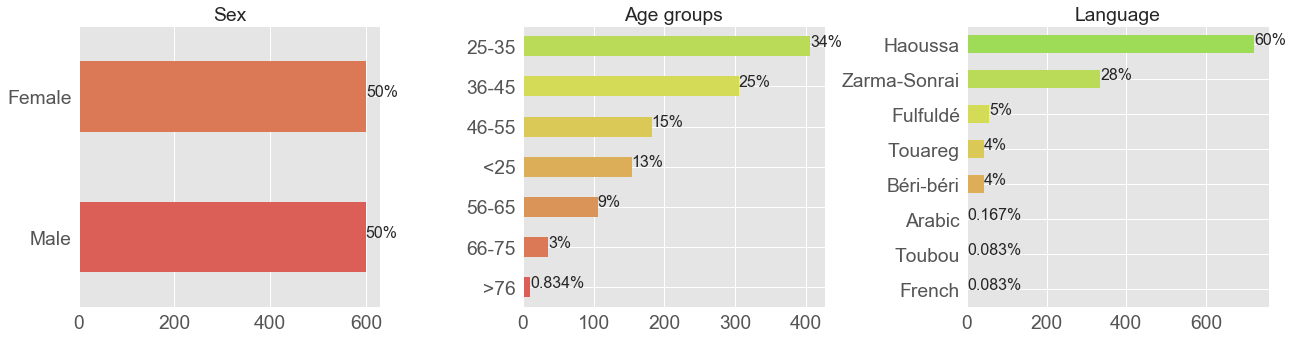

In [26]:
plot_labels([sex,age_groups,languages], titles = ['Sex','Age groups','Language'], save_as = 'sex_age_lang_distribution')

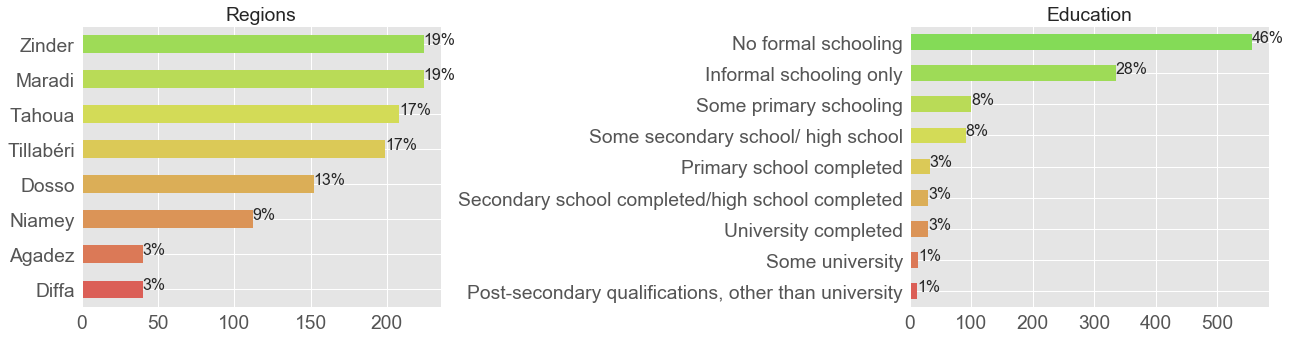

In [27]:
plot_labels([regions.copy(),education], titles = ['Regions','Education'],save_as = 'edu_regions_distribution')

## Plotting distributions of bribe types

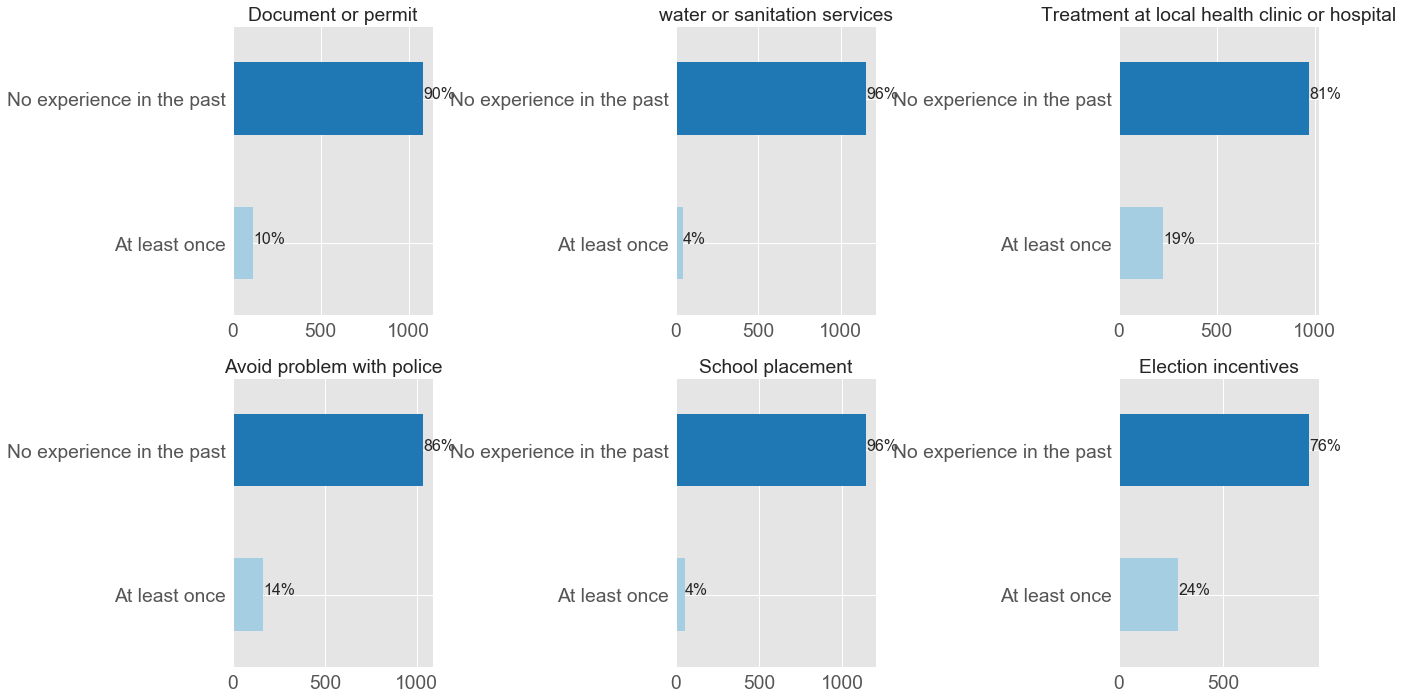

In [28]:
rcParams['figure.figsize'] =  19,10
types_corruption_labels = {0:'No experience in the past',1:'At least once',2:'At least once',3:'At least once',7:'No experience in the past'}
df_bribes = df.loc[:,'Q61A':'Q61F'].replace(types_corruption_labels,value = None)
plot_briberies_columns(df_bribes,corruption_types = ['Document or permit','water or sanitation services','Treatment at local health clinic or hospital',
                                        'Avoid problem with police','School placement','Election incentives']
                      ,save_as = 'bribes_niger')


## Getting pivot tables

In [29]:
df_pivot = pd.DataFrame()
df_pivot['regions'] = regions
df_pivot['sex'] = sex
df_pivot['education'] = education
df_pivot['languages'] = languages
df_pivot['Age groups'] = age_groups

df_pivot['Election incentives'] = df_bribes['Q61F'].replace({'No experience in the past':0,'At least once':1},value = None)
table_1 = get_pivot_table(df_pivot,values='Election incentives',index=['Age groups','sex'],columns=['education'])
table_1.style.apply(color_max)

In [30]:
table_2 = get_pivot_table(df_pivot,values='Election incentives',index=['regions','sex'],columns=['education'])
table_2.style.apply(color_max)

## Getting most type of bribes by country

In [31]:
types = get_most_type_corruption_in_countries(df_gouvernane)

## Setting encoded countries values to categorical

In [32]:
country_names = ['Algeria','Burundi','Benin','Burkina Faso','Botswana',
'Cameroon','Cote d‟Ivoire','Cape Verde','Egypt','Ghana',
'Guinea','Kenya','Lesotho','Liberia','Madagascar','Mauritius',
'Mali','Malawi','Morocco','Mozambique','Namibia','Niger','Nigeria',
'South Africa','Senegal','Sierra Leone','Sudan','Swaziland',
'Tanzania','Togo','Tunisia','Uganda','Zambia','Zimbabwe']

In [33]:
df_type_corrup_by_country = pd.DataFrame(types)
df_type_corrup_by_country.country.replace(df_type_corrup_by_country.country.unique(),country_names, inplace = True)

In [34]:
df_type_corrup_by_country.type.unique()
encode_types = {'Avoid problem with police':0, 'Document or permit':1,
       'Election incentives':2,
       'Treatment at local health clinic or hospital':3}
df_type_corrup_by_country.type.replace(encode_types, inplace = True)

# Plotting most type of bribes by country

In [35]:
plot_choropleth(df = df_type_corrup_by_country,colorscale = 'RdBu', z = df_type_corrup_by_country.type, layout_title = '',
               colorbar_title = "Type of bribes", tickvals = list(encode_types.values()),
                ticktext =list(encode_types.keys()))

In [36]:
plot_choropleth(df = df_type_corrup_by_country, z = df_type_corrup_by_country.percentage, layout_title = 'Bribes frequence',colorscale = 'Rainbow',
               colorbar_title = "Frequence", tickmode = 'auto',tickvals = list(encode_types.values()),
                ticktext =list(encode_types.values()))

## Setting target variable and dropping outliers from data

In [37]:
labels = df['Q61F']
del df['Q61F']
indices_non_outliers = get_non_outliers_index(df.copy())
df, labels, regions, education, age_groups, sex,languages = df[indices_non_outliers],labels[indices_non_outliers],regions[indices_non_outliers], education[indices_non_outliers],age_groups[indices_non_outliers], sex[indices_non_outliers],languages[indices_non_outliers]

Number of outliers 120


## New labels distribution

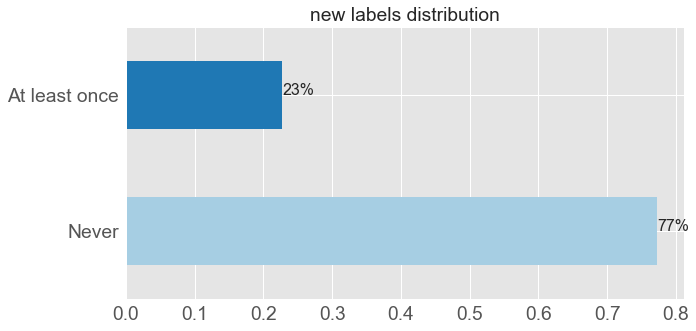

In [43]:
labels = labels.replace({2:1,3:1,4:1}, value = None)
labels = labels.replace({0:'Never',1:'At least once'},value = None)
counts = labels.value_counts()
counts = counts / counts.sum()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
counts.plot(kind = 'barh',color = paired_colors, figsize = (10,5),title = 'new labels distribution', ax = ax)
save_fig(fig,'new_label_repartition')
annotate(counts,ax)

# Dimentionaly reduction and data visualisation

In [35]:
# Scaling data
df_scaled = StandardScaler().fit_transform(df)

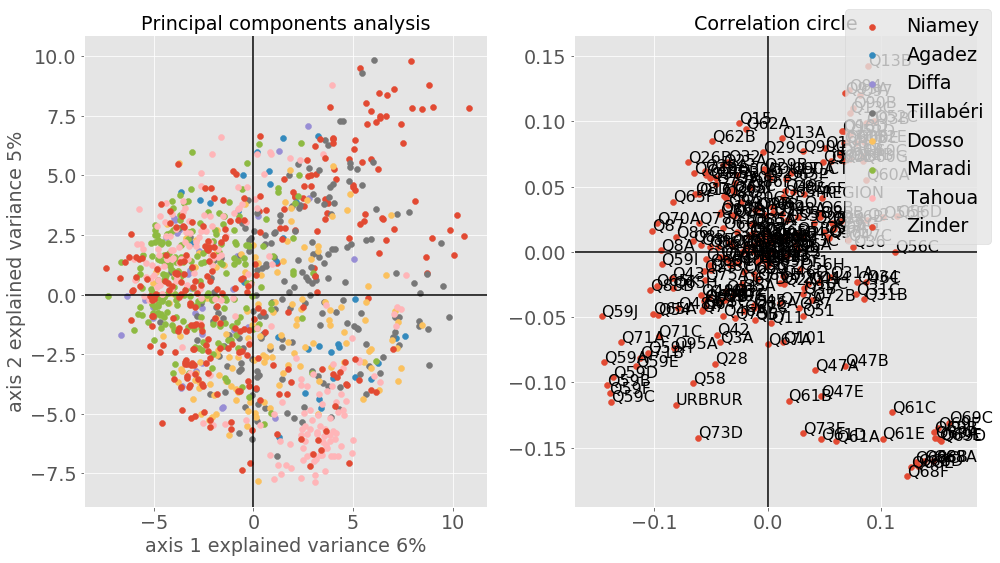

In [47]:
Pca = PCA(n_components = 2)
pca = Pca.fit_transform(df_scaled)
plot_dim_reduction(pca, regions, Pca.explained_variance_ratio_.round(2), title = 'Principal components analysis',plot_cor_cyle = True, components = Pca.components_.T,columns = df.columns,save_as = 'pca')

In [62]:
df_tahoua = df.loc[regions == 'Tahoua',:]
corr = df_tahoua.corr('spearman')
corr
for col in list(corr):
    max_ = corr[col].max()
    min_ = corr[col].min()
    print(col + ' vs ' + list(corr[col][corr[col] == max_].index)[0] + ' ' + str(max_) + ' , ' + col + ' vs ' + list(corr[col][corr[col] == min_].index)[0] + ' ' + str(min_))

Q1 vs Q1 1.0 , Q1 vs Q101 -0.34971142794183396
Q2 vs Q2 1.0 , Q2 vs Q65C -0.19891872322428386
Q3A vs Q3A 1.0 , Q3A vs Q87 -0.394368568870786
Q3B vs Q3B 1.0 , Q3B vs Q8B -0.4781752526246728
Q4 vs Q4 1.0 , Q4 vs Q42 -0.41785039894163617
Q5A vs Q5A 1.0 , Q5A vs Q58 -0.2342118057381751
Q5B vs Q5B 1.0 , Q5B vs Q58 -0.3172165360402423
Q6A vs Q6A 1.0 , Q6A vs Q72B -0.3688452789861453
Q6B vs Q6B 1.0 , Q6B vs Q72B -0.478026017428848
Q7 vs Q7 1.0 , Q7 vs Q88B -0.23176528395226675
Q8A vs Q8A 1.0 , Q8A vs Q58 -0.40609085507888654
Q8B vs Q8B 1.0 , Q8B vs Q3B -0.4781752526246728
Q8C vs Q8C 1.0 , Q8C vs Q47D -0.42950725821754354
Q8D vs Q8D 1.0 , Q8D vs Q58 -0.47448288231796426
Q8E vs Q8E 1.0 , Q8E vs Q58 -0.43574159562029097
Q9A vs Q9A 1.0 , Q9A vs Q10C -0.3260041773901751
Q9B vs Q9B 1.0 , Q9B vs Q10C -0.2581125010774116
Q10A vs Q10A 1.0 , Q10A vs Q10C -0.9398539929398679
Q10B vs Q10B 1.0 , Q10B vs Q10C -0.42050960552398237
Q10C vs Q10C 1.0 , Q10C vs Q10A -0.9398539929398679
Q11 vs Q11 1.0 , Q11 vs Q

IndexError: list index out of range

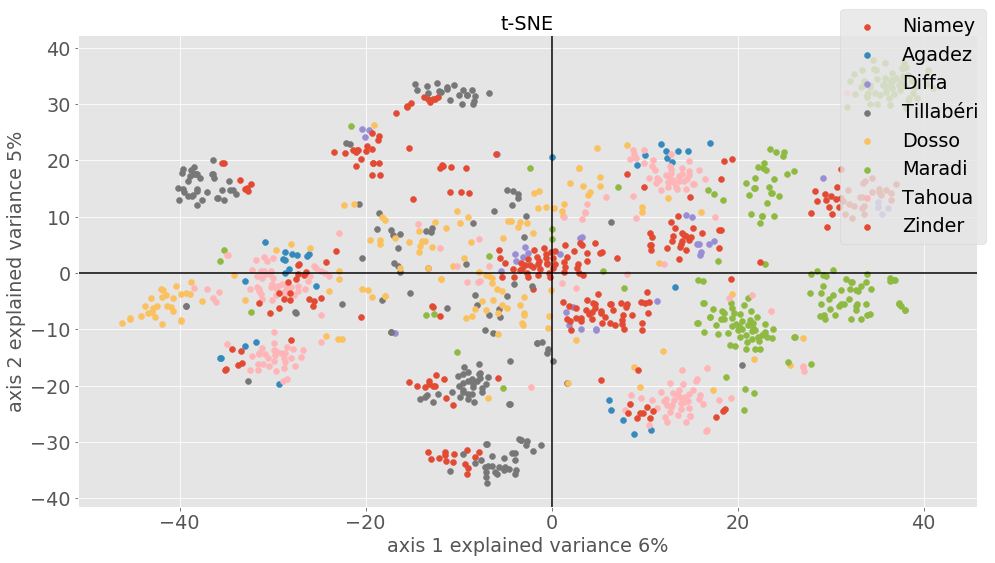

In [63]:
tSNE = TSNE(n_components = 2)
tsne = tSNE.fit_transform(df_scaled)
plot_dim_reduction(tsne, regions, Pca.explained_variance_ratio_.round(2), title = 't-SNE',save_as = 'tsne')

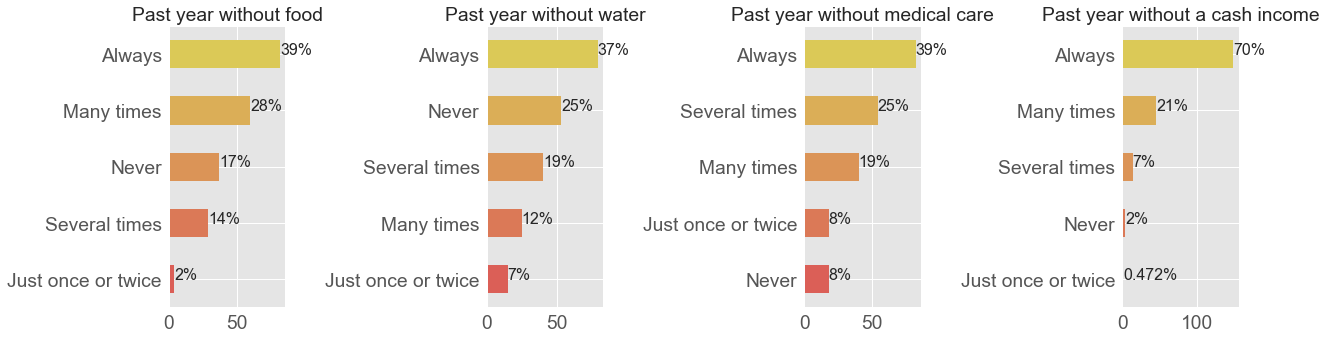

In [39]:
df_maradi = df.loc[regions == 'Maradi',['Q8A','Q8C','Q8E','Q8B']].replace({0:'Never',1:'Just once or twice', 2:'Several times', 3:'Many times', 4:'Always'},value = None)

plot_labels([df_maradi.Q8A,df_maradi.Q8B,df_maradi.Q8C,df_maradi.Q8E], titles = ['Past year without food','Past year without water','Past year without medical care','Past year without a cash income'],
           save_as = 'maradi')

## Looking at the area of respont in Maradi

In [40]:
df.URBRUR[regions =='Maradi'].value_counts()

2    183
1     29
Name: URBRUR, dtype: int64

## Getting most important features but not used in the analyses, just to have an idea 

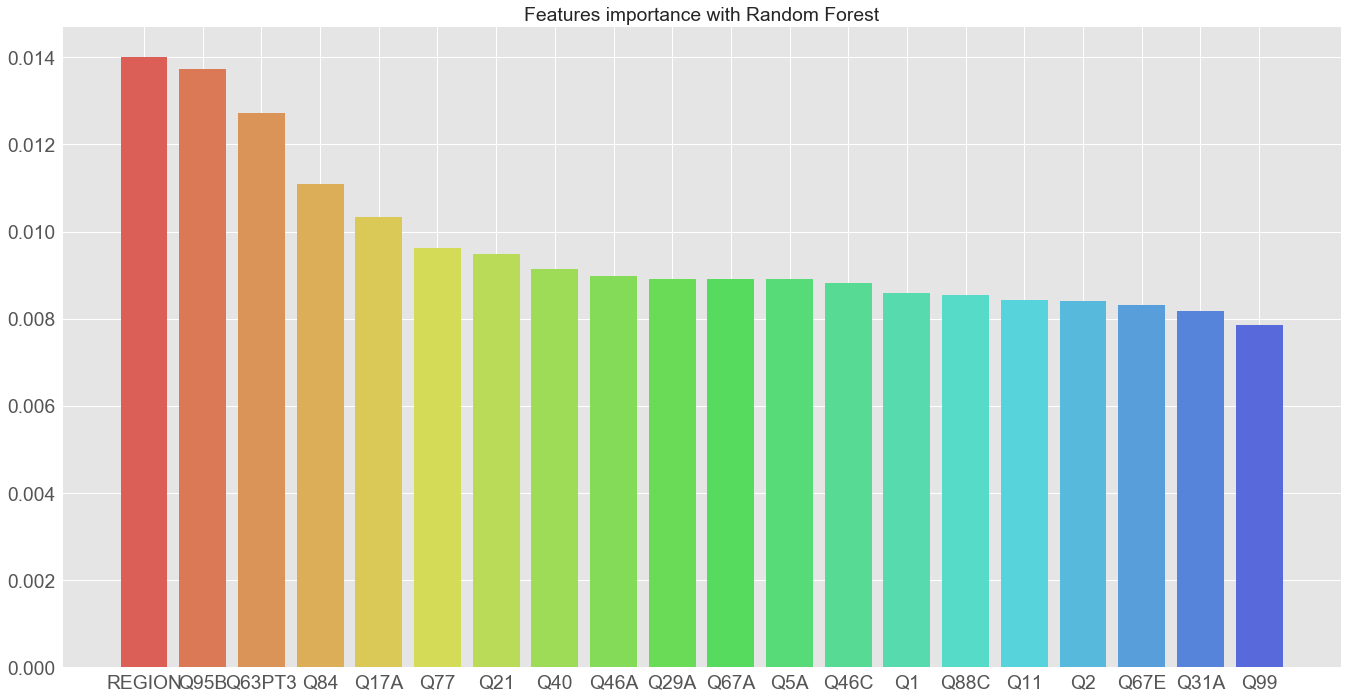

In [46]:

f_names = plot_feature_importance(data = df,labels = labels,classifier = RandomForestClassifier,class_weights = None, n_estimators = 100, criterion = 'gini', keep_n_features = 20,save_as = 'f_IMP')

# Classification

## Splitting data into train and test subsets

In [44]:
labels = labels.replace({'Never':0,'At least once':1},value = None)
x_train,x_test,y_train,y_test = split(df,labels)

## Classification, scores and ROC curves

Random Forest without balanced weights
Accuracy: 0.83
Recall: [0.96911197 0.26153846]
Index: [0 1]
Random Forest with balanced weights
Accuracy: 0.82
Recall: [0.97297297 0.23076923]
Index: [0 1]
Gradient Bosting
Accuracy: 0.82
Recall: [0.92664093 0.38461538]
Index: [0 1]
K nearest neighbors
Accuracy: 0.73
Recall: [0.88803089 0.10769231]
Index: [0 1]
Multi layers perceptrons
Accuracy: 0.65
Recall: [0.67181467 0.53846154]
Index: [0 1]


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

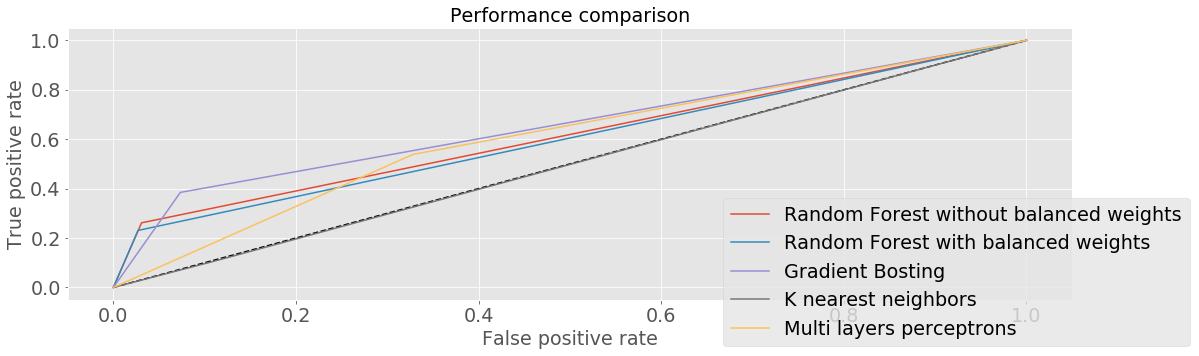

In [67]:
run_classification(x_train,y_train,x_test,y_test, save_as = 'perf_non_balanced')

## Resampling data and running classification

In [68]:
df_resampled, labels_resampled = resample_data(df[f_names],labels)

In [69]:
x_train,x_test,y_train,y_test = split(df_resampled,labels_resampled)

Random Forest without balanced weights
Accuracy: 0.89
Recall: [0.916 0.856]
Index: [0 1]
Random Forest with balanced weights
Accuracy: 0.91
Recall: [0.936 0.876]
Index: [0 1]
Gradient Bosting
Accuracy: 0.87
Recall: [0.9   0.836]
Index: [0 1]
K nearest neighbors
Accuracy: 0.76
Recall: [0.616 0.9  ]
Index: [0 1]
Multi layers perceptrons
Accuracy: 0.58
Recall: [0.256 0.896]
Index: [0 1]


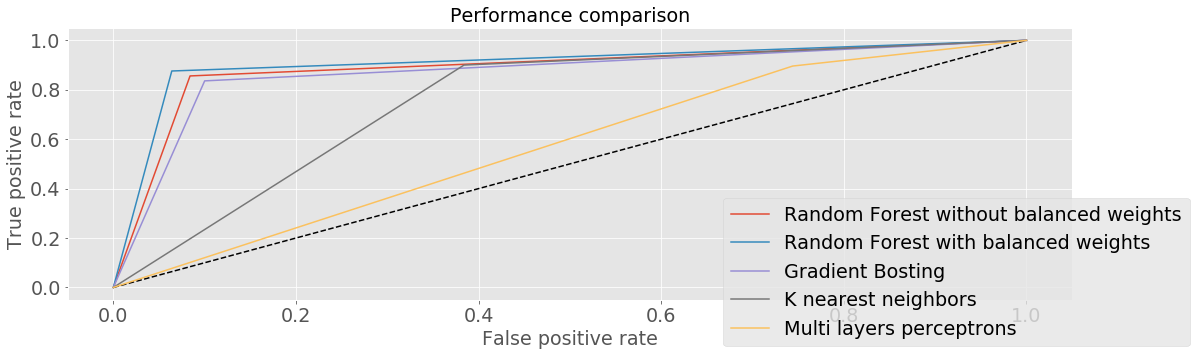

In [70]:
RF_lcf = run_classification(x_train,y_train,x_test,y_test,save_as = 'perf_balanced')

## Exporting one decision tree of random forest with balanced data

In [71]:
 export_decision_tree(RF_lcf.estimators_[0],feature_names = f_names,class_names = ['Never','At least once'])

## Loading decision tree

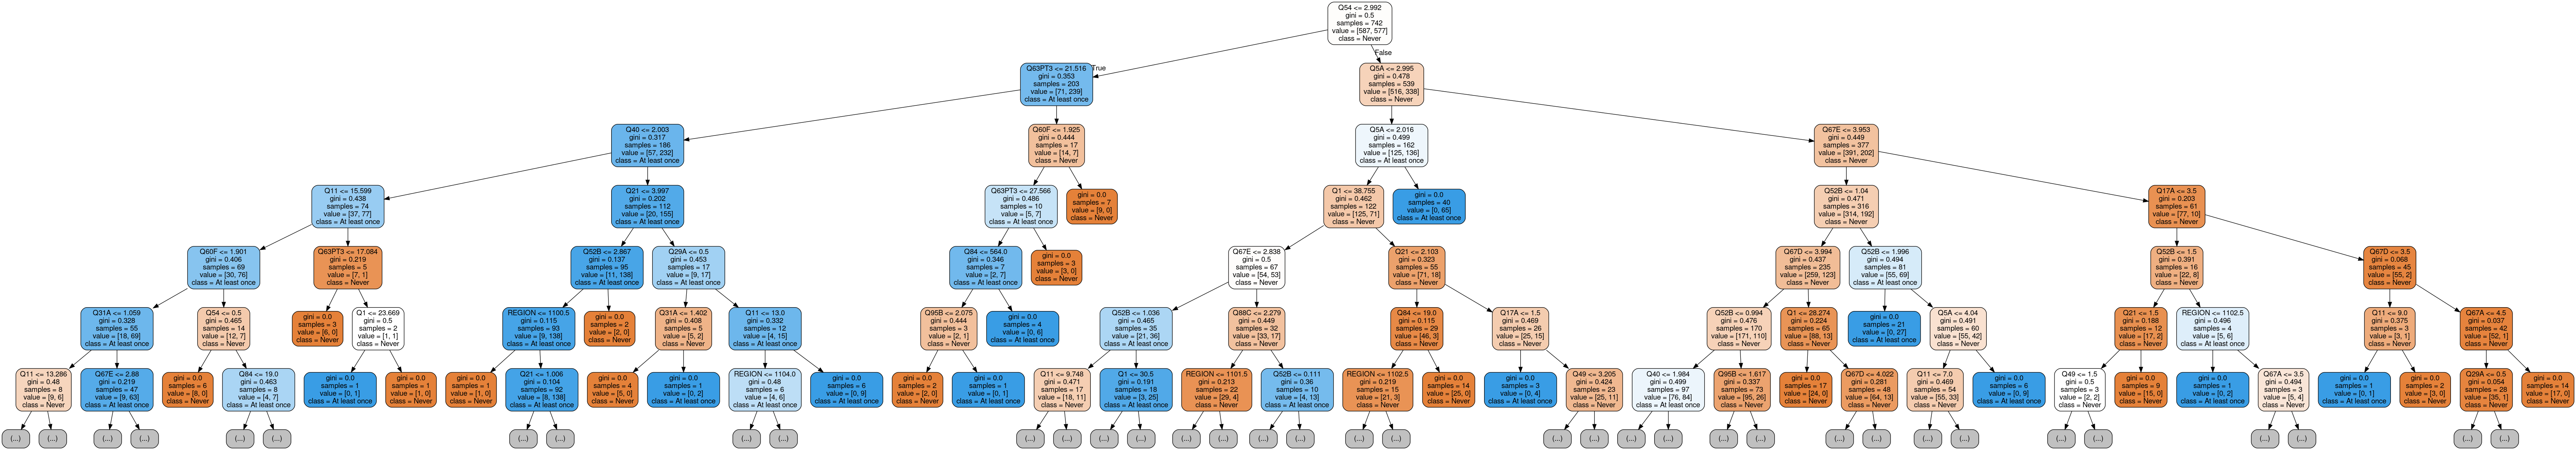

In [72]:
Image('tree.png')